# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm
from linear_operator import settings

import pyro
import math
import pickle
import time
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools

In [ ]:
Device = 'cpu'

In [3]:
Device = 'cuda'

# Read data

In [4]:
TrainData = pd.read_csv('Data/train3D.csv', delimiter=',')
TestData = pd.read_csv('Data/test3D.csv', delimiter=',')

In [5]:
scaler = StandardScaler()
TrainData_standardized = pd.DataFrame(scaler.fit_transform(TrainData), columns=TrainData.columns).values

TestData_standardized = pd.DataFrame(scaler.fit_transform(TestData), columns=TestData.columns).values

X_train = TrainData_standardized[:,0:2]
Y_train = TrainData_standardized[:,-1]

X_test = TestData_standardized[:,0:2]
Y_test = TestData_standardized[:,-1]

In [ ]:
TrainData_log = np.log(TrainData).values
TestData_log = np.log(TestData).values

X_train = TrainData_log[:,0]
Y_train = TrainData_log[:,-1]

X_test = TestData_log[:,0]
Y_test = TestData_log[:,-1]

In [6]:
train_x = torch.tensor(X_train, dtype=torch.float32).to(Device)
test_x = torch.tensor(X_test, dtype=torch.float32).to(Device)

train_y = torch.tensor(Y_train, dtype=torch.float32).to(Device)
test_y = torch.tensor(Y_test, dtype=torch.float32).to(Device)

# Training model

In [7]:
LocalGP_models, LocalGP_likelihoods = Training.train_one_column_StandardGP(
    train_x, train_y, covar_type='RBF', lr=0.05, num_iterations=5000, patience=10, device=Device, use_amp=False
    )

  5%|▍         | 242/5000 [00:01<00:22, 207.10it/s, loss=0.277]


# Prediction

In [ ]:
preds = Prediction.preds_for_one_model(LocalGP_models, LocalGP_likelihoods, test_x)

In [ ]:
preds = Prediction.preds_for_one_model(LocalGP_models, LocalGP_likelihoods, test_x).cpu().detach().numpy()

In [ ]:
np.mean((preds - test_y.numpy()) ** 2)

# Estimation

## Point estimation

In [ ]:
row_idx = 0

bounds = bound.get_bounds(train_x)

estimated_params, func_loss = Estimation.multi_start_estimation(LocalGP_models, LocalGP_likelihoods, row_idx, test_y, bounds, Estimation.estimate_params_for_one_model_Adam, 
                                                                num_starts=5, num_iterations=2000, lr=0.01, patience=10, 
                                                                attraction_threshold=0.1, repulsion_strength=0.5, device=Device)

In [ ]:
test_x[row_idx]

In [ ]:
estimated_params

## MCMC 

In [11]:
# Only can run in .py

if __name__ == '__main__':
    row_idx = 0

    bounds = bound.get_bounds(train_x)

    mcmc_result = Estimation.run_mcmc(Prediction.preds_for_one_model, LocalGP_models, LocalGP_likelihoods, row_idx, test_y, bounds, 
                                                  num_sampling = 1000, warmup_step = 200, num_chains=1, device=Device,jit_compile=False)
    samples = mcmc_result.get_samples()
    print("theta 后验样本：", samples.get('theta'))
    print("sigma 后验样本：", samples.get('sigma'))


Sample: 100%|██████████| 1200/1200 [15:21,  1.30it/s, step size=3.17e-01, acc. prob=0.712]

theta 后验样本： tensor([[ 1.2312,  2.2243],
        [-0.5916,  0.3843],
        [ 0.0078,  1.6338],
        ...,
        [ 0.2655, -0.0785],
        [-0.2042,  0.2847],
        [ 1.3854,  0.6257]], device='cuda:0')
sigma 后验样本： tensor([ 0.2283,  5.3697, 13.9438,  0.9720,  0.9086,  0.6755,  0.6554,  0.6509,
         0.4044,  0.3947,  0.2047,  0.2047,  3.6546,  4.1857,  1.1755,  0.5573,
         2.3854,  0.9522,  1.2388,  6.6828, 13.5470, 13.4358,  9.9434, 17.9348,
         1.6421,  9.1053,  5.6211, 14.1836,  4.1577,  2.3326,  1.3487,  0.3149,
         0.2146,  1.3211,  2.0641,  3.2226, 10.3880,  6.4395,  2.9364,  3.9645,
         0.8275,  1.4484, 15.7952, 11.4831, 15.4199,  5.5404,  5.0288,  6.8639,
         5.4953,  0.4533,  1.7605,  3.5855,  2.1364,  4.4119,  0.4647,  0.3278,
         1.2752,  0.0766,  0.0766,  0.1587,  0.3532,  0.1869,  0.0938,  0.6913,
         0.6720, 15.3887,  0.5774,  1.3710,  8.8819,  0.2139,  0.8064, 15.5388,
         3.0117,  0.1446,  4.1421,  0.8204,  0.5005,  0.4

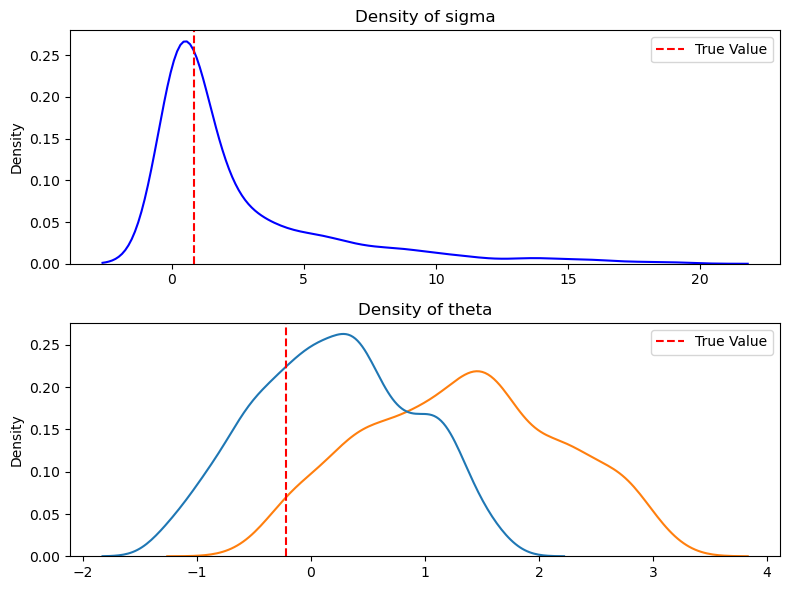

In [14]:
posterior_samples_Normal = mcmc_result.get_samples()

# 如果 test_x 在 GPU 上，则转换为 CPU 的 numpy 数组
true_values = test_x[row_idx, :].cpu().detach().numpy() if hasattr(test_x, "cpu") else test_x[row_idx, :]
point_estimations = None  # 如果有点估计，也需要同样处理

num_params = len(posterior_samples_Normal)
fig, axes = plt.subplots(num_params, 1, figsize=(8, num_params * 3))
if num_params == 1:
    axes = [axes]

for i, (param_name, samples) in enumerate(posterior_samples_Normal.items()):
    ax = axes[i]
    # 将 GPU 上的样本数据转移到 CPU 并转换为 numpy 数组
    samples_np = samples.cpu().detach().numpy() if samples.device.type != 'cpu' else samples.detach().numpy()
    sns.kdeplot(samples_np, ax=ax, color='blue')
    ax.set_title(f'Density of {param_name}')
    
    if true_values is not None and i < len(true_values):
        ax.axvline(true_values[i], color='red', linestyle='--', label='True Value')
    if point_estimations is not None and i < len(point_estimations):
        ax.axvline(point_estimations[i], color='green', linestyle='-.', label='Point Estimation')
    ax.legend()

plt.tight_layout()
plt.show()
